# OnlineSuperLearner example project
In this notebook we present a very basic example of how the OnlineSuperLearner (OSL) can be used. The goal of OSL is to be able to make predictions and do inference on time series data. In order to do so it estimates a density function for each of the covariates, the treatment variables, and the outcome. After these densities are fitted, OSL can simulate interventions and determine the outcome given such an intervention.

## This notebook
In this notebook we will present the steps needed to perform a basic simulation. We will start by installing and configuring the package. Then we approximate our true parameter of interest given the simulation data. This approximated truth is used as ground truth for the rest of the algorithm. In the next step we estimate the densities and run an iteritative sampling method, in which we apply the same treatment as in the approximation step. If everything goes well, both parameters should be approximately the same. Note that this notebook does not apply any TMLE.

## Install dependencies
Before anything else we need to install several dependencies. Most dependencies are used by OSL and some are used by _Condense_. First define the dependencies we need.

In [1]:
# Define the packages we want to install
# Set the can mirror
options(repos = structure(c(CRAN = "http://cran-mirror.cs.uu.nl/")))

gh_packages <- list(
  list(repo = "osofr/condensier", branch = 'fb-add-update')#,
#  list(repo = "frbl/OnlineSuperLearner", branch = 'master')
)

packages <- c("devtools","mockery","RCurl","jsonlite","data.table","R.utils","R.methodsS3","R.oo","simcausal",
              "xgboost","nnls","sgd","dplyr","magrittr","optimr","nloptr","purrr","doParallel","foreach","matrixStats",
              "digest","future", "h2o")

Now install the dependencies:

In [2]:
install <- function(packages, installfunc, ...){
  new.packages <- packages[!(packages %in% installed.packages()[, "Package"])]
  if (length(new.packages))
    installfunc(new.packages, ...)
  update.packages(lib.loc = Sys.getenv("R_LIBS_USER"), ask = FALSE)
}

install(packages, install.packages)
invisible(lapply(gh_packages, function(pkg) install(pkg$repo, devtools::install_github, ref = pkg$branch,
                                                    force = TRUE)))

from URL https://api.github.com/repos/osofr/condensier/zipball/fb-add-update
Installing condensier
'/opt/conda/lib/R/bin/R' --no-site-file --no-environ --no-save --no-restore  \
  --quiet CMD INSTALL  \
  '/tmp/RtmpmSul2b/devtools27749301603/osofr-condensier-2568f22'  \
  --library='/usr/local/spark-2.1.0-bin-hadoop2.7/R/lib' --install-tests 



And then load the actual packages. We will use the local version from source.

In [3]:
# Set a seed and genereal helpers, load the packages
set.seed(12345)
expit = plogis
logit = qlogis

packages <- c('condensier', 'OnlineSuperLearner', packages)

if ("package:OnlineSuperLearner" %in% search()) { detach("package:OnlineSuperLearner", unload=TRUE) }
if ("OnlineSuperLearner" %in% rownames(installed.packages())) { remove.packages("OnlineSuperLearner") }
install.packages('.', repos = NULL, type="source")

suppressWarnings(
    invisible(lapply(packages, require, character.only = TRUE))
)

Removing package from ‘/usr/local/spark-2.1.0-bin-hadoop2.7/R/lib’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/spark-2.1.0-bin-hadoop2.7/R/lib’
(as ‘lib’ is unspecified)
Loading required package: condensier
condensier
The condensier package is still in beta testing. Interpret results with caution.
Loading required package: OnlineSuperLearner
Loading required package: R6
OnlineSuperLearner
The OnlineSuperLearner package is still in beta testing. Interpret results with caution.
Loading required package: devtools

Attaching package: ‘devtools’

The following object is masked _by_ ‘.GlobalEnv’:

    install

Loading required package: mockery
Loading required package: RCurl
Loading required package: bitops
Loading required package: jsonlite
Loading required package: data.table
Loading required package: R.utils
Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.7.1 (2016-02-15) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.21.0 (20

Check if the correct functions are exported.`

In [4]:
getNamespaceExports("OnlineSuperLearner")

[1] "SMG.Mock"                               
 [2] ".__T__&:base"                           
 [3] ".__T__c:base"                           
 [4] ".__T__$:base"                           
 [5] ".__T__[:base"                           
 [6] ".__T__[<-:base"                         
 [7] "SummaryMeasureGenerator.generate_bounds"
 [8] "SummaryMeasureGenerator"                
 [9] "Data.Static"                            
[10] "CrossValidationRiskCalculator"          
[11] "Data.Stream.Simulator"                  
[12] ".__T__|:base"                           
[13] "SMG.Lag"                                
[14] "OnlineSuperLearner.Simulation"          
[15] "Simulator.GAD"                          
[16] "SMGFactory"                             
[17] "OnlineSuperLearner"                     
[18] ".__T__[[<-:base"                        
[19] "Evaluation.get_evaluation_function"     
[20] "RandomVariable"                         
[21] ".__T__$<-:base"                         
[22] "Data.Stream"

## Configuration
The next step is to configure several parameters for the estimation procedure itself. There are several options to configure:
- `log`: Whether or not we want logging of the application. Logging can be done using the R.utils verbose object, e.g.: `log <- Arguments$getVerbose(-8, timestamp=TRUE)`.
- `condensier_options`: The options to pass to the condensier package.
- `cores`: The number of cores used by OSL
- `training_set_size`: OSL trains the estimator on a number of training examples. After that it evaluates its performance on a different (_test_) set.
- `max_iterations`: OSL will process the trainingset iteratively. That is, it won't use all data in one go, but will use micro batches forn a `max_iterations` number of steps.

In [5]:
# Set the seed
set.seed(12345)

# Do logging?
log <- FALSE

# Should condensier fit our estimators in parallel?
condensier_options(parfit=FALSE)

# How many cores would we like to use?
cores = parallel::detectCores()

# Number of items we have in our testset
training_set_size <- 200

# Number of iterations we want to use (this is for the online training part)
max_iterations = 3

# The calculator for estimating the risk
cv_risk_calculator <- OnlineSuperLearner::CrossValidationRiskCalculator$new()

Now the basic configuration for the OSL is done, we can go ahead and specify which intervention we are interested in. Interventions are specified as an R `list` with three elements:
1. _when_: When should the intervention be done? (i.e., at what time $t$)
2. _what_: What should be the intervention we are doing? (e.g., set treatment to $x \in \{0,1\}$)
3. _variable_: Which variable do we consider the intervention variable? ($A$ in the TL literature)

In [6]:
# Number of iterations for approximation of the true parameter of interest
B <- 1e2

# The intervention we are interested in
intervention  <- list(when = c(2), what = c(1), variable = 'A')

# The time of the outcome we are interested in
tau = 2

## Simulation
In order to have some data to use for testing, we have to create a simulator. This simulator uses the simulation scheme as defined in _Blaauw, Chambaz and van der Laan, in prep._. For this scheme we can define various things for each of the data generating systems:
1. _stochMech_: the mechanism we use to generate the observations
2. _param_: the number of steps $t$ the mechanism is connected to the past
3. _rgen_: the mechanism for generating the observations

In [7]:
complex_treatment = FALSE

# Our covariate definition
llW <- list(
  stochMech=function(numberOfBlocks) {
    rnorm(numberOfBlocks, 0, 10)
  },
  param=c(0, 0.5, -0.25, 0.1),
  rgen=identity
)

# The treatment mechanism
llA <- list(
  stochMech=function(ww) {
    rbinom(length(ww), 1, expit(ww))
  },
  param=c(-0.1, 0.1, 0.25),
  rgen=function(xx, delta=0.05){
    probability <- delta+(1-2*delta)*expit(xx)
    rbinom(length(xx), 1, probability)
  }
)

# The outcome variable
if (complex_treatment) {
    rgenfunction = function(AW){
      aa <- AW[, "A"]
      ww <- AW[, grep("[^A]", colnames(AW))]
      mu <- aa*(0.4-0.2*sin(ww)+0.05*ww) + (1-aa)*(0.2+0.1*cos(ww)-0.03*ww)
      rnorm(length(mu), mu, sd=0.1)
    } 
} else {
      rgenfunction = function(AW){
      aa <- AW[, "A"]
      ww <- AW[, grep("[^A]", colnames(AW))]
      mu <- aa*(0.9) + (1-aa)*(0.3)
      rnorm(length(mu), mu, sd=0.1)
    }
}
llY <- list(rgen = rgenfunction)

Now, using these mechanisms we need to setup our simulator. First we define the 'truth', or in our case, an approximation of the true parameter of interest. This parameter specifies what we expect to receive if we would run the earlier specified intervention

In [8]:
# Create the simulator
simulator  <- OnlineSuperLearner::Simulator.GAD$new()


# Approximate the truth under the treatment
result.approx <- mclapply(seq(B), function(bb) {
  when <- max(intervention$when)
  data.int <- simulator$simulateWAY(tau, qw = llW, ga = llA, Qy = llY,
                                    intervention = intervention, verbose = log)
  data.int$Y[tau]
}, mc.cores = cores) %>%
  unlist

psi.approx <- mean(result.approx)

print(psi.approx)

[1] 0.906727


The next step is to use the mechanisms to create a test set of data. Note that we are wrapping our data in a `Data.Static` object. By doing so, we can easily swap this static dataframe out for a stream of incoming data.

In [9]:
data.train <- simulator$simulateWAY(training_set_size + B + 100, qw=llW, ga=llA, Qy=llY, verbose=log)
data.train.static <- OnlineSuperLearner::Data.Static$new(dataset = data.train)

## The OnlineSuperLearner initialization
Now everything is set-up, we can start our super learner procedure. First let's choose a set of estimators we wish to include in our learner. Note that OSL automatically creates a grid of learners based on te hyperparameters provided in the setup.

In [10]:
algos <- list()
#algos <- list(list(description='ML.H2O.randomForest-1tree',
                      #algorithm = 'ML.H2O.randomForest',
                      #params = list(ntrees = 1)))

#algos <- append(algos, list(list(description='ML.H2O.randomForest-50trees',
                      #algorithm = 'ML.H2O.randomForest',
                      #params = list(ntrees = 50))))

#algos <- append(algos, list(list(description='ML.H2O.gbm',
                      #algorithm = 'ML.H2O.gbm')))

algos <- append(algos, list(list(algorithm = 'ML.XGBoost',
                       algorithm_params = list(alpha = 0),
                       params = list(nbins = c(6,40), online = TRUE))))

#algos <- append(algos, list(list(algorithm = 'ML.H2O.gbm',
                      #algorithm_params = list(ntrees=c(10,20), min_rows=1),
                      #params = list(nbins = c(6), online = TRUE))))

#algos <- append(algos, list(list(algorithm = 'ML.H2O.randomForest',
                      #algorithm_params = list(ntrees=c(10,20)),
                      #params = list(nbins = c(6), online = TRUE))))

algos <- append(algos, list(list(algorithm = 'condensier::speedglmR6',
                      #algorithm_params = list(),
                      params = list(nbins = c(3,4, 5), online = FALSE))))

#algos <- append(algos, list(list(algorithm = 'condensier::glmR6',
                      ##algorithm_params = list(),
                      #params = list(nbins = c(16, 20, 24, 30, 34, 40), online = FALSE))))

We use the loglikelihood loss function as general loss function. In order to do so, we should make sure that we bound all variables between $0$ and $1$. We create bounds for all variables in order to do so.

In [11]:
bounds <- OnlineSuperLearner::SummaryMeasureGenerator.generate_bounds(data.train)

The next step is to define our random variables. In this example we only consider the default variables $W$, $A$, and $Y$. Each of them is univariate, and the $A$ variable is a binary variable. Currently we only support the variable at time $t$ ($W$, $A$, or $Y$) and a lagged version therof ($*\_lag\_*$, e.g., $A\_lag\_1$):

In [12]:
W <- OnlineSuperLearner::RandomVariable$new(formula = Y ~ A + W, family = 'gaussian')
A <- OnlineSuperLearner::RandomVariable$new(formula = A ~ W + Y_lag_1 + A_lag_1 + W_lag_1, family = 'binomial')
Y <- OnlineSuperLearner::RandomVariable$new(formula = W ~ Y_lag_1 + A_lag_1 +  W_lag_1 + Y_lag_2, family = 'gaussian')
randomVariables <- c(W, A, Y)

Then we need to create a system that will define our summary measure generator. This step is a bit cumbersome and will be removed in later versions. The idea is that given the definition provided in the previous code block, we have to generate several variables (e.g. the lags). In order to do so, we use a SummaryMeasureGenerator, which will parse these formulae and create the necessary summary measures.

In [13]:
smg_factory <- OnlineSuperLearner::SMGFactory$new()
summaryMeasureGenerator <- smg_factory$fabricate(randomVariables, bounds = bounds)

The last step is to actually run and fit our SuperLearner and calculate its CV risk:

In [14]:
osl  <- OnlineSuperLearner::OnlineSuperLearner$new(algos, summaryMeasureGenerator = summaryMeasureGenerator, verbose = log)
risk <- osl$fit(data.train.static, randomVariables = randomVariables,
                initial_data_size = training_set_size / 2,
                max_iterations = max_iterations,
                mini_batch_size = (training_set_size / 2) / max_iterations)

[1] "Fitting OnlineSuperLearner with a library: ML.XGBoost-alpha-0.nbins-6_online-TRUE, ML.XGBoost-alpha-0.nbins-40_online-TRUE, condensier::speedglmR6-vanilla.nbins-3_online-FALSE, condensier::speedglmR6-vanilla.nbins-4_online-FALSE, condensier::speedglmR6-vanilla.nbins-5_online-FALSE and we use an initial data size of 100 with 3 iterations, and a minibatch of 33"


Warning message in private$perform_optimization(weights = private$weights, epsilon = private$epsilon, :
“
 Trying to start from the border, so doing nothing... 
”Warning message in private$perform_optimization(weights = private$weights, epsilon = private$epsilon, :
“
 Trying to start from the border, so doing nothing... 
”Warning message in private$perform_optimization(weights = private$weights, epsilon = private$epsilon, :
“
 Trying to start from the border, so doing nothing... 
”Warning message in private$perform_optimization(weights = private$weights, epsilon = private$epsilon, :
“
 Trying to start from the border, so doing nothing... 
”Warning message in private$perform_optimization(weights = private$weights, epsilon = private$epsilon, :
“
 Trying to start from the border, so doing nothing... 
”Warning message in private$perform_optimization(weights = private$weights, epsilon = private$epsilon, :
“
 Trying to start from the border, so doing nothing... 
”Warning message in private$p

In order to see how well it can estimate we first generate our data set we want to use for testing as follows:

In [15]:
datas <- summaryMeasureGenerator$getNext(n = B)

In [16]:
do_parallel <- FALSE
if (do_parallel) {
    result <- mclapply(seq(B), function(i) {
        osl$sample_iteratively(data = datas[i,],
                           randomVariables = randomVariables,
                           intervention = intervention,
                           tau = tau)[tau, 'Y']
    }, mc.cores= cores)
} else {
    result <- foreach(i=seq(B), .combine=rbind) %do% {
        osl$sample_iteratively(data = datas[i,],
                           randomVariables = randomVariables,
                           intervention = intervention,
                           tau = tau)[tau, 'Y']
    }
}

result %<>% unlist


And to see the results, we plot them:

[1] "We have approximated psi as 0.906727031917993 our estimate is 0.746000901477847 which is a difference of: 0.160726130440145"


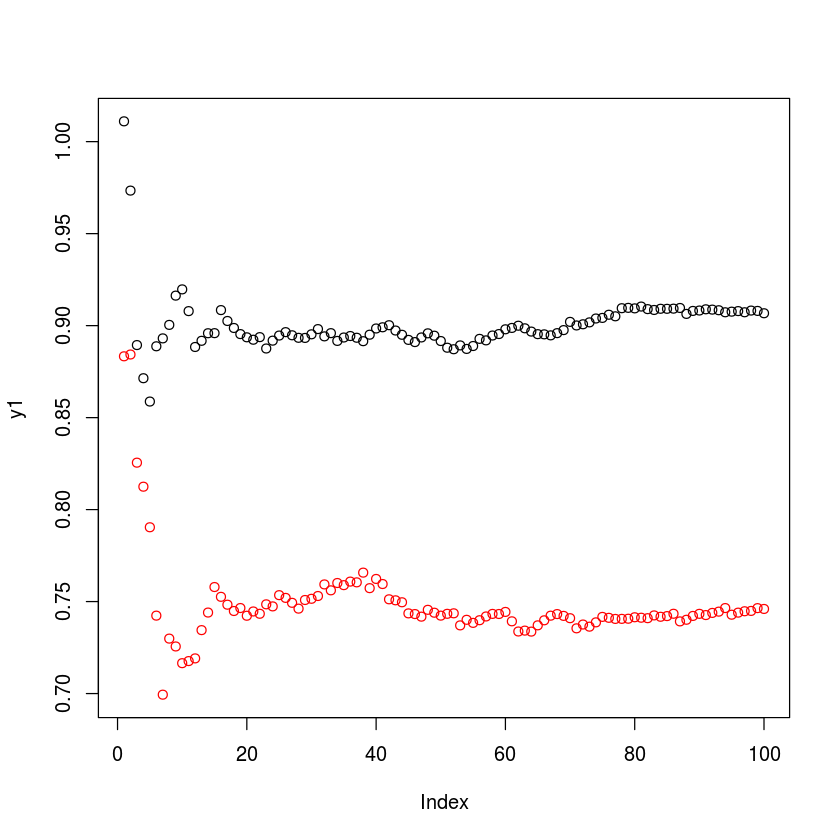

In [17]:
# Calculate psi
psi.estimation <- mean(result)

# Plot the convergence
y1 <- cumsum(result.approx)/seq(along=result.approx)
y2 <- cumsum(result)/seq(along=result)

plot(y1, ylim=range(c(y1,y2)))
par(new=TRUE)
plot(y2, ylim=range(c(y1,y2)), col="red", axes = FALSE, xlab = "", ylab = "")

# Print the outcome
print(paste('We have approximated psi as', psi.approx, 
            'our estimate is', psi.estimation, 
            'which is a difference of:', abs(psi.approx - psi.estimation)))